# Sniffer Classifer
- Author: Sharon Fitzpatrick 
- Date April 2022
</br>
</br>
CNN that distinguishes between "good" and "bad" imagery. Based on the image sorting tool Sniffer. Intended purpose is to quickly sort through geospatial imagery and filter out bad imagery such as images with large segments missing, cloudy  images, or images with errors.

In [97]:
import matplotlib.pyplot as plt
from skimage import io
import seaborn as sns
# import sklearn
from sklearn.metrics import confusion_matrix

import glob
import os
import pandas as pd
import numpy as np
from PIL import Image

import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers

# from keras import regularizers, optimizers
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.metrics import Accuracy, FalseNegatives, FalsePositives, TrueNegatives,TruePositives, Precision, Recall, AUC

# Allows for matplot's to be displayed inline
%matplotlib inline

## Local Variables
Use these variables to change the training parameters for your CNN.
- `dataset_path`: directory containing the  unzipped imagery
- `img_shape` : shape (width , height) your imagery will be resized to. These are inputs into the model.
- `imgs`: list containing all the jpgs  the model will be trained on

In [2]:
dataset_path=os.getcwd()+os.sep+"images"
imgs=glob.glob(dataset_path+os.sep+"*.jpg")
img_shape=(100, 100)
print("In {0} there are {1:n} images".format(dataset_path,len(imgs)))

In c:\1_USGS\2_Machine_Learning\3_sniffer_classifier\Sniffer-Classifier\images there are 741 images


## Augmenting the Dataset
Create an image generator to apply augmentations to the imagery.
- standardizes the image sizes 
- applies zooms, flips, rotations to the imagery

In [3]:
train_datagen=ImageDataGenerator(rescale=1./255.,
rotation_range=20,
zoom_range=0.05,
width_shift_range=0.05,
height_shift_range=0.05,
shear_range=0.05,
horizontal_flip=True,
fill_mode="nearest",
validation_split=0.20
)

test_datagen=ImageDataGenerator(rescale=1./255.)


## Process the Imagery
---------------
1. Prepare the csv by one hot encoding the labels

# Read in the  csv file and transform in df
1. read in the csv
2. one hot encode the sorted labels
3. Update the one hot encoded labels to strings

In [38]:
def clean_csv(csv: str,labels=["good","bad"]):
    """Takes in the name of the csv file to clean (ex. 'master.csv') and a list labels to one hot encode.
        Returns the modified dataframe.
    """
    df =  pd.read_csv(csv)
    if "index" in df.columns:
        print("Dropping column index")
        df.drop(['index'],axis=1,inplace=True)
    if "Unnamed: 0"in df.columns:
        print("Dropping column Unnamed: 0")
        df.drop(['Unnamed: 0'],axis=1,inplace=True)
    return df

In [48]:
df=clean_csv("master.csv")
df

Dropping column Unnamed: 0


,Filename,Sorted
0,2000-01-07-18-21-07_L5_rgb.jpg,bad
1,2000-04-12-18-20-29_L5_rgb.jpg,bad
2,2000-04-28-18-21-24_L5_rgb.jpg,good
3,2000-08-02-18-23-18_L5_rgb.jpg,bad
4,2000-08-18-18-23-46_L5_rgb.jpg,good
...,...,...
736,2018-12-31-15-40-54_S2_ID02022-04-22.jpg,good
737,2018-12-31-15-40-54_S2_ID12022-04-22.jpg,good
738,2018-12-31-15-40-54_S2_ID22022-04-22.jpg,good
739,2018-12-31-15-40-54_S2_ID32022-04-22.jpg,good


In [40]:
def one_encode_labels(df:'pandas.core.frame.DataFrame',labels=["good","bad"]):
  """ Returns the modified dataframe with the labels one hot encoded"""
  mapping = {}
  for x in range(len(labels)):
    mapping[labels[x]] = x
  # outputs {'good': 0, 'bad': 1}
  # Replace each label in sorted with corresponding one hot encoded label
  for x in range(len(df['Sorted'])):
    df['Sorted'][x] = mapping[df['Sorted'][x]]
  return df

In [49]:
df=one_encode_labels(df)
df

,Filename,Sorted
0,2000-01-07-18-21-07_L5_rgb.jpg,1
1,2000-04-12-18-20-29_L5_rgb.jpg,1
2,2000-04-28-18-21-24_L5_rgb.jpg,0
3,2000-08-02-18-23-18_L5_rgb.jpg,1
4,2000-08-18-18-23-46_L5_rgb.jpg,0
...,...,...
736,2018-12-31-15-40-54_S2_ID02022-04-22.jpg,0
737,2018-12-31-15-40-54_S2_ID12022-04-22.jpg,0
738,2018-12-31-15-40-54_S2_ID22022-04-22.jpg,0
739,2018-12-31-15-40-54_S2_ID32022-04-22.jpg,0


## Random OverSampling
Currently the dataset is imbalanced because the number of good and bad samples are not equal to each other.
Use Random oversampling so that the the number of samples in both classes are equal.

In [54]:
def random_oversampling(df,over_sample_class):
    """Apply random oversampling to the dataframe"""
    # Count the number of entries in both classes
    class_count_1,class_count_0=df['Sorted'].value_counts()
    # Divide the dataframe into the two classes
    class_0_df=df[df["Sorted"]==0]
    class_1_df=df[df["Sorted"]==1]
    # Oversample the the dataframe
    if over_sample_class == 0:
        # Oversample the 0 class by taking the class_0_df and use the df.sample() to create class_count_1 samples
        class_over_0=class_0_df.sample(class_count_1,replace=True)
        # Create a new dataframe with the oversampled class
        df =pd.concat([class_over_0,class_1_df],axis=0)
    elif over_sample_class == 1:
         # Oversample the 0 class by taking the class_0_df and use the df.sample() to create class_count_1 samples
        class_over_1=class_1_df.sample(class_count_0,replace=True)
        # Create a new dataframe with the oversampled class
        df =pd.concat([class_0_df,class_over_1],axis=0)
    return df

class_count_0: 390
class_count_1: 390


<AxesSubplot:title={'center':'Count(target)'}>

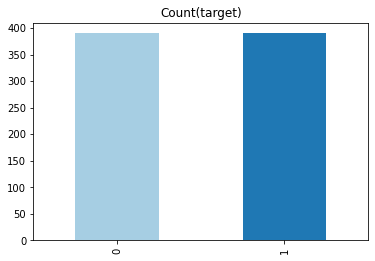

In [62]:
class_count_1,class_count_0=df['Sorted'].value_counts()
print(f"class_count_0: {class_count_0}")
print(f"class_count_1: {class_count_1}")
df['Sorted'].value_counts().plot(kind="bar",title='Count(target)',color=plt.cm.Paired(np.arange(len(df))))
if class_count_0 < class_count_1:
    # oversample class_count_0
    df=random_oversampling(df,0)
elif  class_count_0 > class_count_1:
    # oversample class_count_1
    df=random_oversampling(df,1)

<AxesSubplot:title={'center':'Count(target)'}>

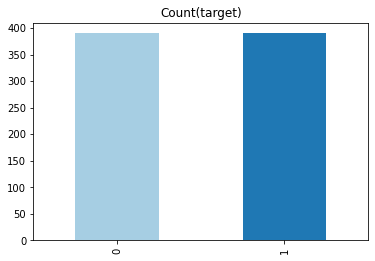

In [63]:
df['Sorted'].value_counts().plot(kind="bar",title='Count(target)',color=plt.cm.Paired(np.arange(len(df))))

## Create the Data Generators
---

In [67]:
def get_training_dataframes(df):
    """Returns the training and test dataframes
    Splits the dataframe int a .75 and .25 training and test set respectively"""
    # Convert the sorted column to string otherwises data generators will not work
    df["Sorted"]=df["Sorted"].astype(str)
    # Split the dataframe into a train and test set into a .75 and .25 training and test set respectively
    # get the first 500 rows
    traindf=df.iloc[:500,:]
    # get the remaining rows
    testdf=df.iloc[500:,:]
    return  traindf,testdf

In [70]:
def get_column_names(df):
    """ x (data) and y (labels) column names from the dataframe """
    x_col_name=df.columns[0]
    y_col_name=df.columns[1]
    return x_col_name,y_col_name

## Flow the images from the dataframe
- resize the images 
- shuffle the images
- divide the data into a training and validation subset
- set a random seed

In [77]:
traindf,testdf=get_training_dataframes(df)
x_col_name,y_col_name=get_column_names(df)

train_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=dataset_path,
x_col=x_col_name,   # image filenames
y_col=y_col_name,   # labels 
subset="training",
batch_size=25,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=img_shape)

valid_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=dataset_path,
x_col=x_col_name, #image filenames
y_col=y_col_name,   # class names in this case good/bad
subset="validation", #only difference is this
batch_size=10, #135/6=15
seed=42,
shuffle=True,
class_mode="categorical",
target_size=img_shape)


Found 400 validated image filenames belonging to 2 classes.


## Create the Model
----
Create a simple Sequential Model

In [132]:
def prepare_model():
    metrics=[TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), Accuracy(name="accuracy"), Precision(name="precision"), Recall(name="recall"),AUC(name="AUC")]
    model = keras.Sequential()
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=img_shape+(3,)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=metrics)
    return model

In [133]:
model = prepare_model()

In [134]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 21, 21, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 10, 10, 32)      

In [137]:
history=model.fit(train_generator,
                    validation_data = train_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=15)

Epoch 1/15
16/16 [==============================] - 13s 818ms/step - loss: 0.5114 - tp: 308.0000 - fp: 92.0000 - tn: 308.0000 - fn: 92.0000 - accuracy: 0.0000e+00 - precision: 0.7700 - recall: 0.7700 - AUC: 0.8388 - val_loss: 0.3819 - val_tp: 217.0000 - val_fp: 33.0000 - val_tn: 217.0000 - val_fn: 33.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.8680 - val_recall: 0.8680 - val_AUC: 0.9264
Epoch 2/15
16/16 [==============================] - 11s 713ms/step - loss: 0.3126 - tp: 356.0000 - fp: 44.0000 - tn: 356.0000 - fn: 44.0000 - accuracy: 0.0050 - precision: 0.8900 - recall: 0.8900 - AUC: 0.9323 - val_loss: 0.2658 - val_tp: 230.0000 - val_fp: 20.0000 - val_tn: 230.0000 - val_fn: 20.0000 - val_accuracy: 0.0300 - val_precision: 0.9200 - val_recall: 0.9200 - val_AUC: 0.9538
Epoch 3/15
16/16 [==============================] - 11s 669ms/step - loss: 0.2385 - tp: 373.0000 - fp: 27.0000 - tn: 373.0000 - fn: 27.0000 - accuracy: 0.0400 - precision: 0.9325 - recall: 0.9325 - AUC: 0.9646 - va

## Evaluate Model Performance
---

In [136]:
score = model.evaluate(valid_generator)
print(score)
print('Test loss:', score[0])
print('True Positives:', score[1])
print('False Positives:', score[2])
print('True Negatives:', score[3])
print('False Negatives:', score[4])
print('Accuracy:', score[5])
print('Precision:', score[6])
print('Recall:', score[7])
print('AUC:', score[8])

10/10 [==============================] - 2s 150ms/step - loss: 0.5529 - tp: 73.0000 - fp: 27.0000 - tn: 73.0000 - fn: 27.0000 - accuracy: 0.0000e+00 - precision: 0.7300 - recall: 0.7300 - AUC: 0.8714
[0.552876889705658, 73.0, 27.0, 73.0, 27.0, 0.0, 0.7300000190734863, 0.7300000190734863, 0.871399998664856]
Test loss: 0.552876889705658
True Positives: 73.0
False Positives: 27.0
True Negatives: 73.0
False Negatives: 27.0
Accuracy: 0.0
Precision: 0.7300000190734863
Recall: 0.7300000190734863
AUC: 0.871399998664856


In [87]:
metrics_df = pd.DataFrame(history.history)

### Plot some graphs to evaluate the model performance

<AxesSubplot:>

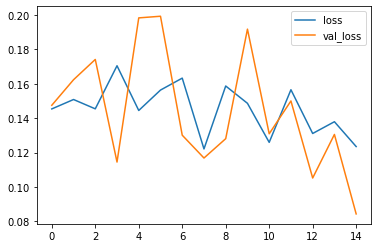

In [88]:
metrics_df[["loss","val_loss"]].plot()

<AxesSubplot:>

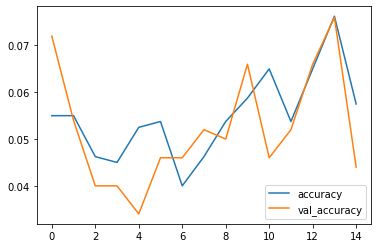

In [89]:
metrics_df[["accuracy","val_accuracy"]].plot()

<AxesSubplot:>

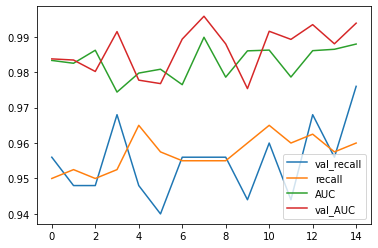

In [90]:

metrics_df[["val_recall","recall","AUC","val_AUC"]].plot()

<AxesSubplot:>

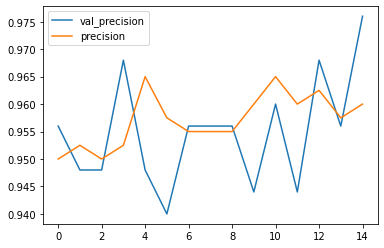

In [91]:

metrics_df[["val_precision","precision"]].plot()

## Save the Model and Training Metrics
1. Create a folder with the name of the model the user provides to store all the data in
2. Save the metrics dataframe as a csv
3. Save the actual model

In [128]:
# Enter the name of your model
model_name="model_100_x_100"

In [117]:
def save_model_data(model_name:str,model:'keras.engine.sequential.Sequential',metrics_df:pd.DataFrame):
    # Create a directory to store all the model data
    model_save_path=os.getcwd()+os.sep+"models"
    if not os.path.exists(model_save_path):
        os.mkdir(model_save_path)
    model_save_path=os.getcwd()+os.sep+"models"+os.sep+model_name
    if os.path.exists(model_save_path):
        raise FileExistsError(f"This folder '{model_name}' already exists: {model_save_path}.\n Please rename your model.")
    else:
        os.mkdir(model_save_path)
    # Save the model history (training metrics) to csv
    metrics_df.to_csv(model_save_path+ os.sep+"model_metrics.csv",index=False)
    # Save the actual model
    model.save(model_save_path+os.sep+"model")

In [119]:
# This might take a few seconds
save_model_data(model_name,model,metrics_df)

INFO:tensorflow:Assets written to: c:\1_USGS\2_Machine_Learning\3_sniffer_classifier\Sniffer-Classifier\models\model_100_x_100\model\assets
